In [ ]:
# Import Necessary Modules

import numpy as np
import tensorflow as tf

In [ ]:
from model import create_dataset

X, Y = create_dataset('data/images/', 'data/masks/')
X_train = X[:4000]
y_train = Y[:4000]
X_val = X[4000:]
y_val = Y[4000:]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

100%|██████████| 5000/5000 [50:50<00:00,  1.64it/s]


Number of examples: 4692


In [ ]:
from model import create_segnet_model


model = create_segnet_model(img_height=128, img_width=128)

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

234553344/234545216 [==============================] - 3s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
____________________

In [ ]:
# Create checkpoint to store model with best performance
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'resnet152v2.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max', save_weights_only=True)


In [ ]:
model_history = model.fit(X_train, y_train, epochs=25, validation_data= (X_val, y_val), callbacks=[checkpoint])

Epoch 1/25
125/125 [==============================] - 137s 1s/step - loss: 0.5704 - accuracy: 0.6907 - val_loss: 2.1093 - val_accuracy: 0.5537
Epoch 2/25
125/125 [==============================] - 136s 1s/step - loss: 0.4744 - accuracy: 0.7708 - val_loss: 1.2666 - val_accuracy: 0.5797
Epoch 3/25
125/125 [==============================] - 136s 1s/step - loss: 0.4311 - accuracy: 0.8001 - val_loss: 0.7281 - val_accuracy: 0.6277
Epoch 4/25
125/125 [==============================] - 136s 1s/step - loss: 0.4095 - accuracy: 0.8124 - val_loss: 0.8997 - val_accuracy: 0.7081
Epoch 5/25
125/125 [==============================] - 137s 1s/step - loss: 0.3745 - accuracy: 0.8306 - val_loss: 0.9352 - val_accuracy: 0.7114
Epoch 6/25
125/125 [==============================] - 132s 1s/step - loss: 0.3530 - accuracy: 0.8417 - val_loss: 1.0525 - val_accuracy: 0.6939
Epoch 7/25
125/125 [==============================] - 136s 1s/step - loss: 0.3308 - accuracy: 0.8533 - val_loss: 0.4950 - val_accuracy: 0.8076

In [ ]:
# Load model weights with highest performance on validation set

model.load_weights(checkpoint_path)

In [ ]:
from model import create_test_dataset

X_test, y_test = create_test_dataset('data/test_images/', 'data/test_masks/')

100%|██████████| 120/120 [00:00<00:00, 271.78it/s]

Number of examples: 121


In [ ]:
# Evaluate Test Set Accuracy
from keras.metrics import Accuracy
metric = Accuracy()

test_predictions = format_output(model.predict(X_test))
test_labels = (np.argmax(y_test, axis=2).reshape((-1,128,128,1)))
metric.update_state(test_predictions, test_labels)
print("Test Pixelwise Accuracy:", metric.result().numpy())

Test Pixelwise Accuracy: 0.6884669


In [ ]:
# Evaluate with Mean IoU
from keras.metrics import MeanIoU

metric = MeanIoU(num_classes=2)

train_predictions = format_output(model.predict(X_train))
train_labels = (np.argmax(y_train, axis=2).reshape((-1,128,128,1)))
metric.update_state(train_predictions, train_labels)
print("Training Mean IoU:", metric.result().numpy())

val_predictions = format_output(model.predict(X_val))
val_labels = (np.argmax(y_val, axis=2).reshape((-1,128,128,1)))
metric.update_state(val_predictions, val_labels)
print("Validation Mean IoU:", metric.result().numpy())

test_predictions = format_output(model.predict(X_test))
test_labels = (np.argmax(y_test, axis=2).reshape((-1,128,128,1)))
metric.update_state(test_predictions, test_labels)
print("Test Mean IoU:", metric.result().numpy())

Training Mean IoU: 0.8937295
Validation Mean IoU: 0.8716491
Test Mean IoU: 0.8614446


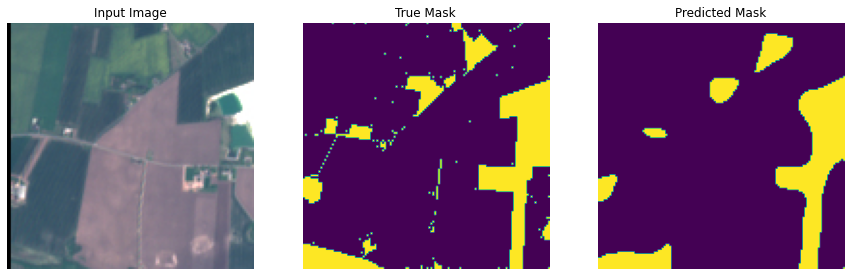

In [ ]:
# Check Train and Validation Images
from visualize import format_output, display

image_num = 6
out = tf.reshape(format_output(model.predict(X[image_num].reshape((1,128,128,3))), display=True), [128,128,1])
picture = (X[image_num].reshape((128,128,3)))
label = (np.argmax(Y[image_num], axis=1).reshape((128,128,1)))
display([picture, label, out])

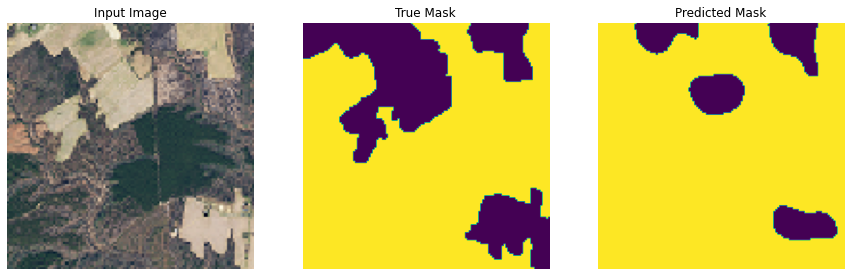

In [ ]:
# Check Test Images
from visualize import format_output, display

image_num = 7
out = tf.reshape(format_output(model.predict(X_test[image_num].reshape((1,128,128,3))), display=True), [128,128,1])
picture = (X_test[image_num].reshape((128,128,3)))
label = (np.argmax(y_test[image_num], axis=1).reshape((128,128,1)))
display([picture, label, out])